Here we explore different truncate direction to see if our assumption:
- Recursion doesn't lead to better metrics result because scientific texts probably provide simple summarization in the introduction, thus making reading in the whole text in recursion possibly only noisy and not helpful.
- (Of course a 2nd assumption could be that rouge and bert are just not good enough metrics, so the small difference in the result may not be that indicative of how good the generated abstracts are)

...could be valid by trying out different truncation methods:
- top to bottom: the first 1024 tokens in the text are used to generate abstracts
- bottom to top: the last 1024 tokens in the text are used to generate abstracts

And fine-tune our short-form models (bart, distilbart, pegasus) with the bottom truncation dataset for evaluation with the differently truncated datasets.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
scaledown = 20000
article_max_len = 1024
abstract_max_len = 400 # rough max of dataset
#  Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96
folder_name = "bart-pubmed-20k_bottom-tokens"
huggingface_model = "facebook/bart-large-cnn"
# Replace the above 2 lines also for distil and pegasus

from huggingface_hub import notebook_login
notebook_login()


In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 353 µs (started: 2024-04-29 18:17:37 +00:00)


In [ ]:
!pip install wandb

time: 5.26 s (started: 2024-04-29 18:17:37 +00:00)


In [ ]:
import wandb
wandb.init(project="FineTune-TextSummarize", name=folder_name)

wandb: Currently logged in as: airolg1111. Use `wandb login --relogin` to force relogin


time: 9.24 s (started: 2024-04-29 18:17:42 +00:00)


Fine Tuning summarization model on PubMed

In [ ]:
!pip install datasets
!pip install accelerate -U

  Using cached accelerate-0.29.3-py3-none-any.whl (297 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 k

In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import pipeline
import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset

time: 8.78 s (started: 2024-04-29 18:18:58 +00:00)


# Redo the dataset creation with longform tokenzier

Redo the process in the dataset creation & analsys notebook because we need to use a tokenzier with large enough token limit to tokenize 4096 tokens to be able to truncate and keep the bottom 1024 tokens.

In [ ]:
dataset = load_dataset("ccdv/pubmed-summarization", download_mode="force_redownload")

df_train = pd.DataFrame(dataset['train']).dropna()
df_test = pd.DataFrame(dataset['test']).dropna()
df_val = pd.DataFrame(dataset['validation']).dropna()

if scaledown:
  df_train = df_train[:scaledown]
  test_size = int(scaledown*.1) if int(scaledown*.1) >= 1 else 1
  df_test = df_test[:test_size]
  df_val = df_val[:test_size]
  print('after scale down to ', scaledown, 'with test size ', test_size)
  print(f"Train dataset size: {len(df_train)}")
  print(f"Test dataset size: {len(df_test)}")
  print(f"Test dataset size: {len(df_val)}")

# Convert DataFrames to Hugging Face Datasets
dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)
dataset_val = Dataset.from_pandas(df_val)

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': dataset_train,
    'test': dataset_test,
    'validation': dataset_val
})

dataset_med = dataset_dict

## Get lengths of train, test and val data
split_train_test_val = [len(dataset_med[split]) for split in dataset_med]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Shift all computations to GPU

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

## !! Use a tokenzier with longer token allowance
tokenizer_index = "longformer-pubmed-20k"
my_tokenizer = "Chung-Fan/longformer-pubmed-20k"
long_tokenizer_model = "hyesunyun/update-summarization-bart-large-longformer"

model_ckpt = huggingface_model
tokenizer = AutoTokenizer.from_pretrained(long_tokenizer_model)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
# Lists of article and abstract lengths in the med dataset after encoding.
d_len = [len(tokenizer.encode(s)) for s in dataset_med["train"]["article"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_med["train"]["abstract"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (5507 > 1024). Running this sequence through the model will result in indexing errors


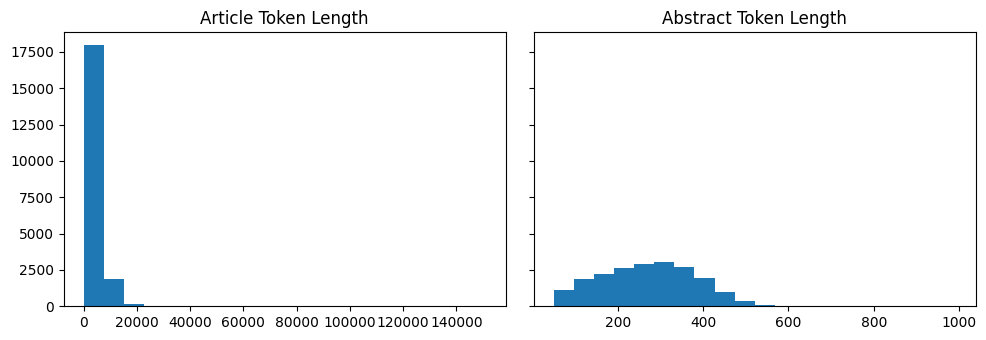

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20)
axes[0].set_title("Article Token Length")
axes[1].hist(s_len, bins=20)
axes[1].set_title("Abstract Token Length")
plt.tight_layout()
plt.show()

# Tokenize validation and test sets as well


In [ ]:
####
# Validation set
####

# Lists of article and abstract lengths in the med dataset after encoding.
d_len_val = [len(tokenizer.encode(s)) for s in dataset_med["validation"]["article"]]
s_len_val = [len(tokenizer.encode(s)) for s in dataset_med["validation"]["abstract"]]

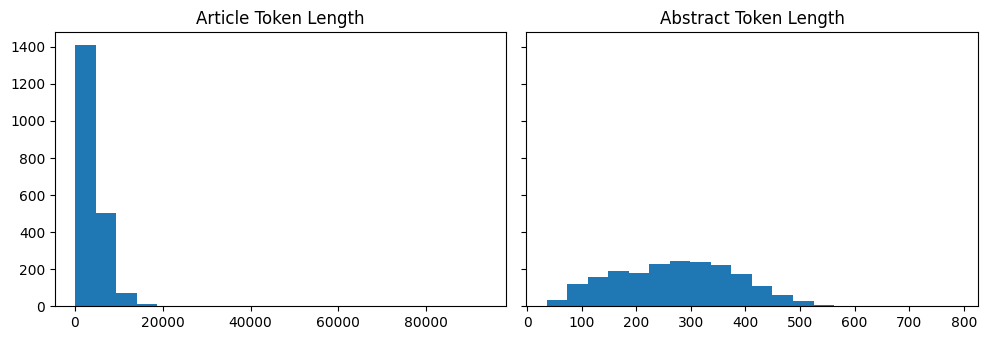

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len_val, bins=20)
axes[0].set_title("Article Token Length")
axes[1].hist(s_len_val, bins=20)
axes[1].set_title("Abstract Token Length")
plt.tight_layout()
plt.show()

In [ ]:
####
# Test set
####

# Lists of article and abstract lengths in the med dataset after encoding.
d_len_test = [len(tokenizer.encode(s)) for s in dataset_med["test"]["article"]]
s_len_test = [len(tokenizer.encode(s)) for s in dataset_med["test"]["abstract"]]

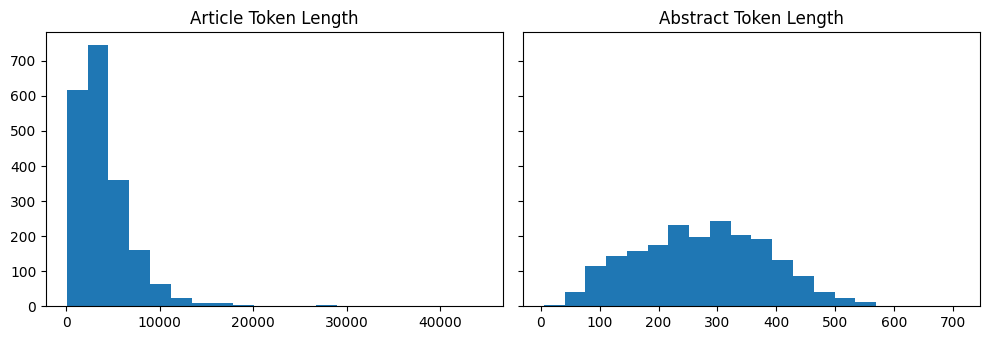

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len_test, bins=20)
axes[0].set_title("Article Token Length")
axes[1].hist(s_len_test, bins=20)
axes[1].set_title("Abstract Token Length")
plt.tight_layout()
plt.show()

# Data Preprocessing
For both train and test
- remove invalid ones (eg. ones with unreasonbly short text, ones where abstract is almost as long or longer than article)
- remove ones with artile tokens longer than 4096, and  because we are trying to  

In [ ]:
####
# Training set
####

token_df = pd.DataFrame(list(zip(d_len, s_len)), columns =['article_len', 'abstract_len'])
token_df.describe()

,article_len,abstract_len
count,20000.000000,20000.000000
mean,4037.903950,271.296300
std,3523.099609,108.656623
min,2.000000,50.000000
25%,1930.000000,187.000000
50%,3335.000000,273.000000
75%,5192.000000,351.000000
max,150981.000000,992.000000


From this, we also see that some entries make no sense since article shouldn't be shorter than abstract. So we want to drop rows with the following trait:
article shorter than abstract

In [ ]:
# remove the entries
# 1. article token > 4k (because we want to compare the difference between a 4k summarizer and 1k summarizer)
# 2. artickle token < abstract token len * 3 (because we want to make sure no entries with a disporportionate length ratio is in)
# 3. abstract > 400 (to save computing power & since the majority of abstracts are < 400 tokens, we want to set generated text max length smaller to fit our dataset)

og_len = scaledown
token_df = token_df.drop(token_df[token_df['article_len'] > 4096].index)
token_df = token_df.drop(token_df[token_df['article_len'] < token_df['abstract_len']*3].index)
token_df = token_df.drop(token_df[token_df['abstract_len'] > 400].index)

print("The number of valid entries is now: ", len(token_df), "(", 100 - int(100*len(token_df)/og_len), "% )" )
token_df.describe()


The number of valid entries is now:  10700 ( 47 % )


,article_len,abstract_len
count,10700.000000,10700.000000
mean,2337.852991,227.668318
std,920.839126,92.263218
min,224.000000,52.000000
25%,1569.750000,150.000000
50%,2248.000000,227.000000
75%,3109.000000,305.000000
max,4096.000000,400.000000


We also want to separate a group of data where article is at most 1024 token long for comparing performance of short & long summarizers on short texts.

In [ ]:
token1024_df = token_df.drop(token_df[token_df['article_len'] > 1024].index)
print("The number of entries with articles shorter than 1024 tokens is: ", len(token1024_df))
token1024_df.describe()

The number of entries with articles shorter than 1024 tokens is:  642


,article_len,abstract_len
count,642.000000,642.000000
mean,833.685358,139.580997
std,153.618063,53.597423
min,224.000000,53.000000
25%,743.500000,98.250000
50%,868.000000,128.500000
75%,951.000000,173.000000
max,1023.000000,339.000000


Now for validation and test

In [ ]:
####
# Validation set
####

token_df_val = pd.DataFrame(list(zip(d_len_val, s_len_val)), columns =['article_len', 'abstract_len'])
token_df_val.describe()

,article_len,abstract_len
count,2000.000000,2000.000000
mean,4028.421500,273.562000
std,3703.601124,109.736421
min,89.000000,36.000000
25%,1995.500000,186.000000
50%,3261.500000,276.000000
75%,5128.250000,353.000000
max,93622.000000,788.000000


In [ ]:
og_len = len(token_df_val)
token_df_val = token_df_val.drop(token_df_val[token_df_val['article_len'] > 4096].index)
token_df_val = token_df_val.drop(token_df_val[token_df_val['article_len'] < token_df_val['abstract_len']*3].index)
token_df_val = token_df_val.drop(token_df_val[token_df_val['abstract_len'] > 400].index)

print("The number of valid entries is now: ", len(token_df_val), "(", 100 - int(100*len(token_df_val)/og_len), "% )" )
token_df_val.describe()

The number of valid entries is now:  1107 ( 45 % )


,article_len,abstract_len
count,1107.000000,1107.000000
mean,2301.277326,226.306233
std,882.753021,90.661000
min,355.000000,36.000000
25%,1544.500000,149.500000
50%,2223.000000,228.000000
75%,3031.500000,302.000000
max,4089.000000,400.000000


In [ ]:
token1024_df_val = token_df_val.drop(token_df_val[token_df_val['article_len'] > 1024].index)
print("The number of entries with articles shorter than 1024 tokens is: ", len(token1024_df_val))
token1024_df_val.describe()

The number of entries with articles shorter than 1024 tokens is:  56


,article_len,abstract_len
count,56.000000,56.000000
mean,846.767857,148.000000
std,157.810703,54.307542
min,355.000000,65.000000
25%,757.750000,105.000000
50%,897.500000,141.000000
75%,979.500000,182.500000
max,1014.000000,326.000000


In [ ]:
####
# Test set
####

token_df_test = pd.DataFrame(list(zip(d_len_test, s_len_test)), columns =['article_len', 'abstract_len'])
token_df_test.describe()

,article_len,abstract_len
count,2000.000000,2000.000000
mean,4061.693500,274.786500
std,3203.056512,111.284918
min,68.000000,5.000000
25%,1981.750000,189.750000
50%,3305.500000,277.000000
75%,5116.000000,356.000000
max,44499.000000,711.000000


In [ ]:
og_len = len(token_df_test)
token_df_test = token_df_test.drop(token_df_test[token_df_test['article_len'] > 4096].index)
token_df_test = token_df_test.drop(token_df_test[token_df_test['article_len'] < token_df_test['abstract_len']*3].index)
token_df_test = token_df_test.drop(token_df_test[token_df_test['abstract_len'] > 400].index)

print("The number of testid entries is now: ", len(token_df_test), "(", 100 - int(100*len(token_df_test)/og_len), "% )" )
token_df_test.describe()

The number of testid entries is now:  1125 ( 44 % )


,article_len,abstract_len
count,1125.000000,1125.000000
mean,2321.511111,228.655111
std,907.849590,91.910670
min,580.000000,5.000000
25%,1564.000000,151.000000
50%,2254.000000,231.000000
75%,3047.000000,306.000000
max,4085.000000,399.000000


In [ ]:
token1024_df_test = token_df_test.drop(token_df_test[token_df_test['article_len'] > 1024].index)
print("The number of entries with articles shorter than 1024 tokens is: ", len(token1024_df_test))
token1024_df_test.describe()

The number of entries with articles shorter than 1024 tokens is:  74


,article_len,abstract_len
count,74.000000,74.000000
mean,873.378378,149.135135
std,124.922738,64.668665
min,580.000000,60.000000
25%,780.000000,96.500000
50%,902.000000,142.000000
75%,979.500000,189.250000
max,1017.000000,320.000000


Now let's create a new "valid" dataset object from the above preprocessed dataframes
- dataset 4096
  - train, test, val
- dataset 1024
  - train, test, val

In [ ]:
####
# Training set
####

token_df['article'] = ''
token_df['abstract'] = ''
token_df.head()

,article_len,abstract_len,article,abstract
2,1572,207,,
4,1540,222,,
5,3490,273,,
6,2237,259,,
7,3719,361,,


In [ ]:
# fill the dataframe with the article and abstract text for further study
index_list = token_df.index.values.tolist()

article_list = []
abstract_list = []

for i in index_list:
  article_list.append(dataset_med["train"][i]["article"])
  abstract_list.append(dataset_med["train"][i]["abstract"])

token_df['article'] = article_list
token_df['abstract'] = abstract_list
token_df.head()

,article_len,abstract_len,article,abstract
2,1572,207,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side effe...
4,1540,222,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...
5,3490,273,"world - wide , infertility affects 1015% of co...",backgroundmicrornas ( mirnas ) play pivotal ro...
6,2237,259,midwife - led primary delivery care for low -...,objective . \n the objective of this study was...
7,3719,361,diabetes decreases the overall life expectancy...,type 2 diabetes is characterized by insulin re...


In [ ]:
token1024_df['article'] = ''
token1024_df['abstract'] = ''
token1024_df.head()

,article_len,abstract_len,article,abstract
14,801,252,,
53,705,64,,
61,801,257,,
66,965,181,,
123,933,113,,


In [ ]:
# fill the dataframe with the article and abstract text for further study
index_list = token1024_df.index.values.tolist()

article_list = []
abstract_list = []

for i in index_list:
  article_list.append(dataset_med["train"][i]["article"])
  abstract_list.append(dataset_med["train"][i]["abstract"])

token1024_df['article'] = article_list
token1024_df['abstract'] = abstract_list
token1024_df.head()

,article_len,abstract_len,article,abstract
14,801,252,a review of the literature and an extensive me...,backgrounda review of the literature and an ex...
53,705,64,"nathan , as an oncology fellow , knew well tha...",t cells tell macrophages when to start making ...
61,801,257,temporary henna tattoos or pseudotattoo have b...,temporary henna tattoos or pseudotattoos have ...
66,965,181,a 55 year - old man visited our emergency depa...,we report a redo coronary artery bypass grafti...
123,933,113,the laparoscopic removal of a cervical stump f...,"a 43-year - old , who underwent a subtotal hys..."


Now for test and val sets of 4096 token size

In [ ]:
####
# Test set
####

token_df_test['article'] = ''
token_df_test['abstract'] = ''

# fill the dataframe with the article and abstract text for further study
index_list = token_df_test.index.values.tolist()

article_list = []
abstract_list = []

for i in index_list:
  article_list.append(dataset_med["test"][i]["article"])
  abstract_list.append(dataset_med["test"][i]["abstract"])

token_df_test['article'] = article_list
token_df_test['abstract'] = abstract_list
token_df_test.head()

,article_len,abstract_len,article,abstract
0,3820,257,anxiety affects quality of life in those livin...,research on the implications of anxiety in par...
1,3409,125,small non - coding rnas are transcribed into m...,"small non - coding rnas include sirna , mirna ..."
3,1170,187,congenital adrenal hyperplasia ( cah ) refers ...,congenital adrenal hyperplasia is a group of a...
6,2273,346,the family is the cornerstone of human social ...,background : since the family is a social syst...
7,3444,333,development of human societies and industriali...,background and objective : anxiety and depre...


In [ ]:
####
# Test set 1024 token
####

token1024_df_test['article'] = ''
token1024_df_test['abstract'] = ''

# fill the dataframe with the article and abstract text for further study
index_list = token1024_df_test.index.values.tolist()

article_list = []
abstract_list = []

for i in index_list:
  article_list.append(dataset_med["test"][i]["article"])
  abstract_list.append(dataset_med["test"][i]["abstract"])

token1024_df_test['article'] = article_list
token1024_df_test['abstract'] = abstract_list
token1024_df_test.head()

,article_len,abstract_len,article,abstract
15,676,124,the femoral head often leads to healing compli...,fracture of the femoral neck continues to be a...
38,821,133,tuberculosis ( tb ) is a major health issue in...,tuberculosis ( tb ) is a major health issue in...
56,950,145,gossypiboma ( retained surgical sponge ) descr...,gossypiboma is a term used to describe a forei...
163,830,129,the prevalence of syphilis in the normal popul...,a 30-yr - old man was referred for suspicious ...
207,721,140,"the pylorus , duodenal c - loop , and ileoceca...",most of the ingested foreign bodies pass uneve...


In [ ]:
####
# val set
####

token1024_df_val['article'] = ''
token1024_df_val['abstract'] = ''

# fill the dataframe with the article and abstract text for further study
index_list = token1024_df_val.index.values.tolist()

article_list = []
abstract_list = []

for i in index_list:
  article_list.append(dataset_med["validation"][i]["article"])
  abstract_list.append(dataset_med["validation"][i]["abstract"])

token1024_df_val['article'] = article_list
token1024_df_val['abstract'] = abstract_list
token1024_df_val.head()

,article_len,abstract_len,article,abstract
20,579,182,an idiopathic epiretinal membrane ( erm ) usua...,we report a case of recurrent epiretinal membr...
112,427,105,"chronic inflammation can continue , resulting ...",we report a case of central venous stenosis du...
121,996,76,"\n a 24-year - old male x , smoking 24 ciga...",baclofen was initially used for the treatment ...
132,706,84,"ophthalmomyiasis , infestation of the eye with...",a 50-year - old male presented with foreign bo...
158,726,149,osteoma is a slow growing benign lesion which ...,osteoma is a benign osteogenic lesion with a v...


# Create bottom up and mid section truncated dataset

In [ ]:
def get_bottom_tokens(text, size=1024):
    tokens = text.split()
    bottom_tokens = tokens[1024:]
    return ' '.join(bottom_tokens)

def get_midsec_tokens(text, size=1024):
    tokens = text.split()
    text_len = len(tokens)
    if text_len > size:
      padding = int((text_len - size)/2)
      mid_tokens = tokens[padding:padding+size]
      return ' '.join(mid_tokens)
    return text

In [ ]:
token_df['mid_article']  = token_df['article'].apply(get_midsec_tokens)
token_df['bottom_article']  = token_df['article'].apply(get_bottom_tokens)

In [ ]:
# Convert DataFrames to Hugging Face Datasets
dataset_train = Dataset.from_pandas(token_df)
dataset_test = Dataset.from_pandas(token_df_test)
dataset_val = Dataset.from_pandas(token_df_val)

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': dataset_train,
    'test': dataset_test,
    'validation': dataset_val
})

dataset_med = dataset_dict
dataset_med

DatasetDict({
    train: Dataset({
        features: ['article_len', 'abstract_len', 'article', 'abstract', '__index_level_0__'],
        num_rows: 10700
    })
    test: Dataset({
        features: ['article_len', 'abstract_len', 'article', 'abstract', '__index_level_0__'],
        num_rows: 1125
    })
    validation: Dataset({
        features: ['article', 'abstract', '__index_level_0__'],
        num_rows: 1107
    })
})

In [ ]:
# Convert DataFrames to Hugging Face Datasets
dataset1024_train = Dataset.from_pandas(token1024_df)
dataset1024_test = Dataset.from_pandas(token1024_df_test)
dataset1024_val = Dataset.from_pandas(token1024_df_val)

# Create DatasetDict
dataset1024_dict = DatasetDict({
    'train': dataset1024_train,
    'test': dataset1024_test,
    'validation': dataset1024_val
})

dataset1024_med = dataset1024_dict
dataset1024_med

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract', '__index_level_0__'],
        num_rows: 642
    })
    test: Dataset({
        features: ['article', 'abstract', '__index_level_0__'],
        num_rows: 74
    })
    validation: Dataset({
        features: ['article', 'abstract', '__index_level_0__'],
        num_rows: 56
    })
})

In [ ]:
# ## Get lengths of train, test and val data
split_train_test_val = [len(dataset_med[split]) for split in dataset_med]
split_train_test_val

[10700, 1125, 1107]

In [ ]:
# ## Get lengths of train, test and val data
split_train_test_val_1024 = [len(dataset1024_med[split]) for split in dataset1024_med]
split_train_test_val_1024

[642, 74, 56]

# Fine-Tuning pretrained model
First with 4096 tokens.

In [ ]:
# tokenize the dataset

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["bottom_article"], max_length=1024, padding="max_length", truncation=True)
    # print('-------------------')
    # print(type(input_encodings), len(input_encodings))


    #Using target_tokenizer for summaries
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["abstract"], max_length=abstract_max_len, padding="max_length", truncation=True)

    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    }

In [ ]:
dataset_med_pt = dataset_med.map(convert_examples_to_features, batched=True)

Map:   0%|          | 0/10700 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1125 [00:00<?, ? examples/s]

Map:   0%|          | 0/1107 [00:00<?, ? examples/s]

In [ ]:
columns = ["input_ids", "labels", "attention_mask"]
dataset_med_pt.set_format(type="torch", columns=columns)

In [ ]:
from transformers import DataCollatorForSeq2Seq
# Collator for Handling length imbalances and attention masks
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer
# debug: https://discuss.huggingface.co/t/trainingargument-does-not-work-on-colab/43372
training_args = TrainingArguments( output_dir= folder_name,
                                 num_train_epochs=1,
                                 warmup_steps=500,
                                 per_device_train_batch_size=1,
                                 per_device_eval_batch_size=1,
                                 weight_decay=0.01,
                                 logging_steps=10,
                                 push_to_hub=True,
                                 evaluation_strategy='steps',
                                 eval_steps=500,
                                 save_steps=1e6,
                                 gradient_accumulation_steps=16,
                                 report_to="wandb" )

In [ ]:
trainer = Trainer(model=model,
                 args=training_args,
                 tokenizer=tokenizer,
                 data_collator=seq2seq_data_collator,
                 train_dataset=dataset_med_pt["train"],
                 eval_dataset=dataset_med_pt["validation"])

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
500,1.265800,1.107660


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


TrainOutput(global_step=668, training_loss=1.5881724828731514, metrics={'train_runtime': 2348.3083, 'train_samples_per_second': 4.556, 'train_steps_per_second': 0.284, 'total_flos': 2.3162013987373056e+16, 'train_loss': 1.5881724828731514, 'epoch': 1.0})

# Store finetuned models


In [ ]:
commit_msg = "Training done for " + folder_name
trainer.push_to_hub(commit_msg)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Chung-Fan/bart-pubmed-20k/commit/020f34b3bb6c1b6e2bfe17a0a0f7e409fd6fe7cc', commit_message='Training done for bart-pubmed-20k', commit_description='', oid='020f34b3bb6c1b6e2bfe17a0a0f7e409fd6fe7cc', pr_url=None, pr_revision=None, pr_num=None)

# Benchmarking

benchmarking is simply using the same script but with the following models, so no extra evaluation notebook for ablation study will be included to avoid redundancy

In [ ]:
model_index = "bart-pubmed-20k-bottom-tokens"
my_model = "Chung-Fan/bart-pubmed-20k-bottom-tokens"
og_model = "facebook/bart-large-cnn"

model_index = "distilbart-pubmed-20k-bottom-tokens"
my_model = "Chung-Fan/distilbart-pubmed-20k-bottom-tokens"
og_model = "philschmid/distilbart-cnn-12-6-samsum"

model_index = "pegasus-pubmed-20k-bottom-tokens"
my_model = "Chung-Fan/pegasus-pubmed-20k-bottom-tokens"
og_model = "tuner007/pegasus_summarizer"